# Kaggle 競賽: Home Credit Default Risk

競賽網址: https://www.kaggle.com/c/home-credit-default-risk

Home Credit (捷信消費金融有限公司) 是中東歐/亞洲的一家消費金融提供商，為客戶提供金融服務。  
他們希望能通過資料探勘和機器學習來判斷客戶的貸款違約機率。

## 資料簡介  
  
Home Credit 提供的資料如下：

1. **application_train/test - 客戶申請表**: 包含了客戶是否違約(1/0的目標變數)、客戶申請貸款資料(貸款類型、貸款總額、年金)、客戶基本資料(性別、 年齡、家庭、學歷、職業、行業、居住地情況)、客戶財務資訊(年收入、房/車狀況)、以及其他申請時提供的資料等等。
  
2. **bureau/bureau_balance - 由其他金融機構提供給徵信單位的客戶信用記錄歷史**: 包含了客戶在徵信單位的信用記錄、違約金額、違約時間等等。以時間序列的形式進行記錄(以月為單位)。
  
3. **POS_CASH_balance - 客戶在Home Credit資料庫中POS(point of sales)和現金貸款紀錄**: 包含了客戶已付款和未付款的狀況(以月為單位)。
  
4. **credit_card_balance - 客戶在Home Credit資料庫中信用卡的紀錄**: 包含了客戶消費次數、消費金額等等(以月為單位)。
  
5. **previous_application - 客戶先前的申請記錄**: 包含了客戶所有歷史申請記錄，如申請資料和申請結果等等。
  
6. **installments_payments - 客戶先前信用卡的還款記錄**: 包含了客戶的還款狀況(還款日期、是否逾期、還款金額、是否欠款等等)。

## 競賽目標

**競賽最終要求提交每個目標ID的違約機率，並以此計算得到的AUC作為評分標準。**


### 評分標準: AUC 簡介

ROC-AUC 是一種常見的分類指標，稱為 [Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

我們可藉由 [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) 繪製出 True Positive Rate (TPR) 和 False Positive Rate (FPR) 的關係圖：

![image](./ROC-curve.png)

然後 [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) 是單純 ROC 底下的涵蓋面積。所以可以看出如上圖，藍色模型優於紅色模型，紅色模型又優於完全隨機亂猜的模型(黑色斜直線)。

## 前置作業

### Imports

基本的python套件: `numpy`, `pandas`, `sklearn`, `matplotlib`

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

### 讀取資料

總共有九個檔案：兩個主要的csv檔可以用來訓練模型(有標籤的是train，沒標籤的是test)，來有其他六個包含額外資訊的csv檔。

In [2]:
print(os.listdir("./input/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [7]:
app_train = pd.read_csv('./input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


訓練資料共有 307511 個觀察點以及 122 個特徵變數 (包含`TARGET`，也就是我們要預測的東西)。

In [8]:
app_test = pd.read_csv('./input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


test資料比較小而且沒有 `TARGET` 欄位。 

## 探索式資料分析

探索式資料分析 (Exploratory Data Analysis, EDA) 是一種探索未知的過程。我們會除了基本的統計分析外，會特別尋找資料中的偏差性、異常值、重複的模式或彼此的關係。EDA的目標是讓我們了解資料，並從中取出可以利用的特徵。我們通常會從 High-Level Overview 開始尋找，然後隨著發現一些規律或有趣的結果後逐漸收斂到較小的分析範圍。

### 檢查標籤分布

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

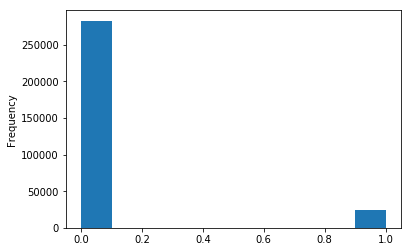

In [6]:
app_train['TARGET'].astype(int).plot.hist()

發現標籤中只有 0 跟 1，而且比例非常不平均(Unbalanced分類問題)。

### 檢查遺失值

In [9]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [10]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


在未來我們會嘗試去填補這些遺失值。

### 特徵資料型態


In [9]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

`int64` 和 `float64` 是數值資料，而 `object` 是類別資料。 

其中 `object` (類別資料) 又可以列出以下類別：

In [10]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

可以發現有些類別很少出現，我們在未來亦需要特別處理它們。

### 對類別資料進行編碼

由於大多數的機器學習或深度學習模型沒辦法處理異質資料(除了一些特別設計的 Decision Tree 或 Gradient Boosting Machine以外)，所以我們會需要找到一個方法去編碼上述的那些類別資料。常見的方法有幾種：

* Label encoding: 將所有類別由 1 編碼到 N，特徵向量維度不變。

![image](./label_encoding.png)

* One-hot encoding: 類似統計上的 Dummy-Variable，但不考慮線性相依問題所以有幾個類別就產生幾維度的特徵向量(如 A、B、C 三類，會直接編碼成\[1,0,0\]、\[0,1,0\]、\[0,0,1\])。 

![image](./one_hot_encoding.png)

Label Encoding 會把所有類別由 1 編碼到 N，所以常常會產生無意義的順序性(比如貓、狗、豬，若編碼成 1、2、3 時可能會讓電腦誤會成他們具有順序性或者數值大小關係)。但 One-hot Encoding 不會。所以我們決定在只有兩類的類別資料實作 Label Encoding，然後其他兩類別以上的類別資料做 One-hot Encoding



我們使用 Scikit-Learn 的 `LabelEncoder` 和 Pandas 的 `get_dummies(df)` 來實作編碼方法。

In [12]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


In [13]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### 建立 Training Set 和 Testing Set

In [14]:
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


### 檢查異常值

我們使用 `describe` 函式來檢視統計敘述。日期相關的值是負的所以我們要加上負號，然後他記錄天數所以我們除以365來以年為單位。



In [14]:
(-app_train['DAYS_BIRTH'] / 365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

我們可以看到 `DAYS_BIRTH` 部分沒有太大的異常。

In [15]:
(-app_train['DAYS_EMPLOYED']/ 365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

這肯定有異常值，最小值-1000並不合理。我們接著檢查 `DAYS_EMPLOYED` 的分布：

Text(0.5,0,'Days Employment')

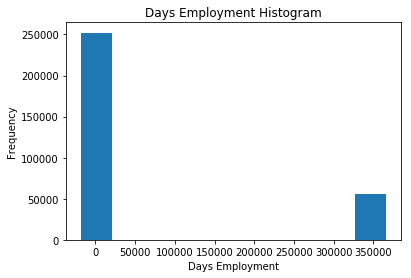

In [16]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

我們發現 `DAYS_EMPLOYED` 的值大多分布在 50000 以下，所以可以合理懷疑 300000 以上的值是異常值。我們把他們都設為 `np.nan`。

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Text(0.5,0,'Days Employment')

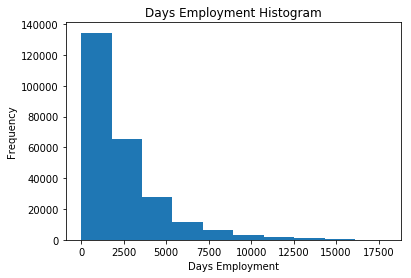

In [16]:
anom = app_train[app_train['DAYS_EMPLOYED'] > 300000]
non_anom = app_train[app_train['DAYS_EMPLOYED'] <= 300000]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] > 300000

rep = {val: np.nan for val in app_train['DAYS_EMPLOYED'] if val > 300000}
app_train['DAYS_EMPLOYED'].replace(rep, inplace = True)

(-app_train['DAYS_EMPLOYED']).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

testing set 也要做同樣的動作(將異常值取代為 `np.nan` )。

In [15]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] > 300000
rep = {val: np.nan for val in app_test['DAYS_EMPLOYED'] if val > 300000}
app_test["DAYS_EMPLOYED"].replace(rep, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### 相關係數

我們直接使用 `.corr` 進行相關係數的計算。

In [18]:
correlations = app_train.corr()
target_corr = correlations['TARGET'].sort_values()

print('Most Positive Correlations:\n', target_corr.tail(15))
print('\nMost Negative Correlations:\n', target_corr.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Text(0.5,1,'Correlation Heatmap')

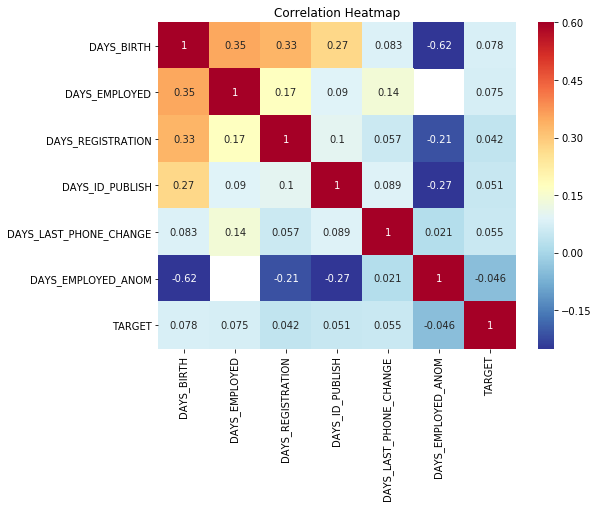

In [21]:
plt.figure(figsize = (8, 6))

plt_data = app_train[[c for c in app_train.columns if 'DAYS_' in c] + ['TARGET']]

sns.heatmap(plt_data.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

可以發現 `DAYS_BIRTH` 是最相關的變數。

由於一般的分布圖沒辦法看出什麼有用的資訊，所以我們使用 [核密度估計](https://en.wikipedia.org/wiki/Kernel_density_estimation) (kernel density estimation, KDE) 來繪製 `DAYS_BIRTH` 和 `TARGET` 的關係圖。 KDE 可以被視為平滑過的直方圖。

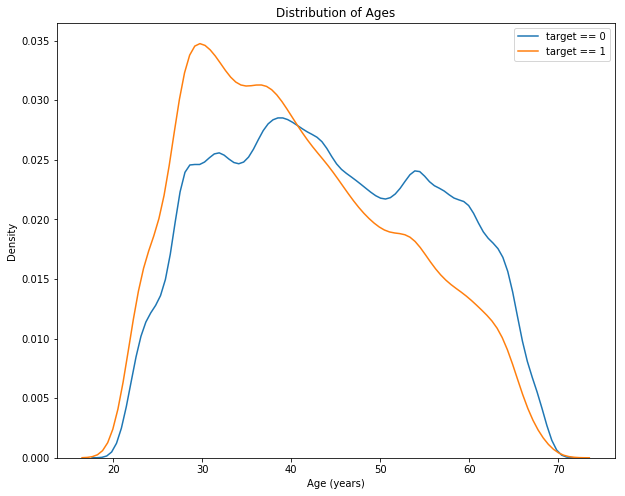

In [22]:
plt.figure(figsize = (10, 8))
sns.kdeplot(-app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

sns.kdeplot(-app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.show()

我們可以發現，沒有違約呈常態分佈，但年齡越低時違約的比例越高。

## 訓練模型

### Baseline

由於是二分類問題，所以最低標準的準確率一定是 0.5。

### Logistic Regression

In [36]:
from sklearn.preprocessing import MinMaxScaler, Imputer

if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
features = list(train.columns)

test = app_test.copy()

imputer = Imputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))
imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [37]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001)

log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.066677
1,100005,0.128855
2,100013,0.084450
3,100028,0.060502
4,100038,0.127878


Logistic Regression 的輸出結果會是機率值，我們也可以設定一個閥值後將它變成1或0的類別(二分類)。

In [40]:
submit.to_csv('log_reg_baseline.csv', index = False)

**Logistic regression 的成績為 0.671。**

### Random Forest

隨機森林演算法是決策樹的延伸，我們也在這邊測試。

In [41]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [42]:
random_forest.fit(train, train_labels)

feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


In [43]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline.csv', index = False)

**Random Forest 的成績為 0.678。**

### Gradient Boosting Machine
Kaggle 競賽中經常見到 [Gradient Boosting Machine](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)，其中 [LightGBM library](http://lightgbm.readthedocs.io/en/latest/Quick-Start.html) 是大家常用的 python 套件之一。我們使用 5-fold 的 Cross validation，然後類別資料一律用 One-hot Encoding 編碼。

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    labels = features['TARGET']
    
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        cat_indices = 'auto'
    
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        
        cat_indices = []
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                cat_indices.append(i)
    
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    feature_names = list(features.columns)
    features = np.array(features)
    test_features = np.array(test_features)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(test_features.shape[0])
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(features):
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
      
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)

        best_iteration = model.best_iteration_
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [24]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 239)
Testing Data Shape:  (48744, 239)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798776	train's binary_logloss: 0.547732	valid's auc: 0.755302	valid's binary_logloss: 0.563582
[400]	train's auc: 0.828115	train's binary_logloss: 0.518495	valid's auc: 0.755183	valid's binary_logloss: 0.54559
Early stopping, best iteration is:
[330]	train's auc: 0.818572	train's binary_logloss: 0.528099	valid's auc: 0.755926	valid's binary_logloss: 0.551342
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798672	train's binary_logloss: 0.547978	valid's auc: 0.758343	valid's binary_logloss: 0.563567
Early stopping, best iteration is:
[289]	train's auc: 0.812801	train's binary_logloss: 0.533928	valid's auc: 0.758486	valid's binary_logloss: 0.555107
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.797711	train's binary_logloss: 0.549295	valid's auc: 0.763014	valid's bina

In [27]:
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()
    
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

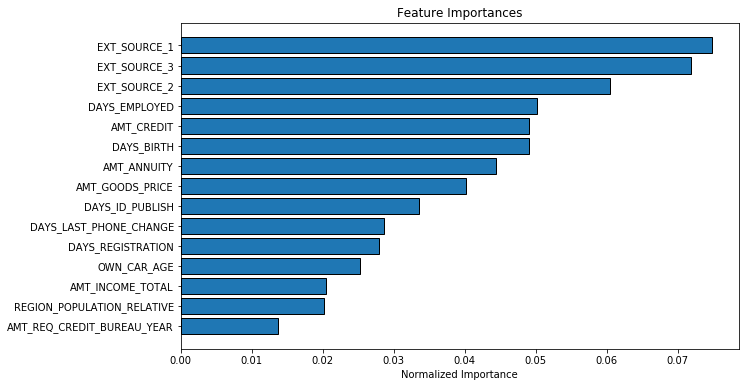

In [28]:
fi_sorted = plot_feature_importances(fi)

In [29]:
submission.to_csv('baseline_lgb.csv', index = False)

**Gradient Boosting Machine 的成績為 0.735。**